In [1]:
import zipfile
import os

# Replace 'your_archive.zip' with the actual name of your ZIP file
zip_file_path = 'BRAIN.zip'
unzip_destination = ''

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified destination
    zip_ref.extractall(unzip_destination)

# Print a message indicating that the extraction is complete
print(f"Contents of '{zip_file_path}' successfully extracted to '{unzip_destination}'.")


Contents of 'BRAIN.zip' successfully extracted to ''.


In [2]:
import warnings
warnings.filterwarnings("ignore")

warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import tensorflow as tf

In [4]:
ROOT_DIR="./brain_tumor_dataset"
number_of_images={}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

In [5]:
number_of_images.items()

dict_items([('no', 98), ('yes', 155)])

In [6]:
def dataFolder(p,split):
    if not os.path.exists("./"+p):
        os.mkdir("./"+p)
        
        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+p+"/"+dir)
            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),
                                        size=(math.floor(split*number_of_images[dir])-5),
                                        replace=False ):
                O=os.path.join(ROOT_DIR,dir,img)
                D=os.path.join("./"+p,dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print(f"{p} folder exists")
                
         
                

In [7]:
dataFolder("train",0.8)

train folder exists


In [8]:
dataFolder("test",0.1)

test folder exists


In [9]:
dataFolder("val",0.1)

val folder exists


In [10]:
number_of_images={}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))
    
number_of_images.items()

dict_items([('no', 98), ('yes', 155)])

In [11]:
#MODEL BUILD

In [12]:
from keras.layers import Conv2D,MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [13]:
#CNN

model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation= 'relu', input_shape=(224,224,3) ))

model.add(Conv2D(filters=36, kernel_size=(3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 36)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)      

In [14]:
model.compile(optimizer='adam',loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [15]:
def preprocessingImages1(path):
    #input path output preproceesed images
    image_data=ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1/255, horizontal_flip=True)
    image=image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode='binary')
    
    return image

In [16]:
path="./train"
train_data=preprocessingImages1(path)

Found 192 images belonging to 2 classes.


In [17]:
def preprocessingImages2(path):
    #input path output preproceesed images
    image_data=ImageDataGenerator(rescale=1/255)
    image=image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode='binary')
    
    return image

In [18]:
path="./test"
test_data=preprocessingImages2(path)

Found 14 images belonging to 2 classes.


In [19]:
path="./val"
val_data=preprocessingImages1(path)

Found 14 images belonging to 2 classes.


In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1, mode='auto')


mc=ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5",verbose=1, save_best_only=True ,mode='auto')

cd=[es,mc]


In [21]:
steps_per_epoch = int(np.ceil(len(train_data.filenames) / 32))
validation_steps = int(np.ceil(len(val_data.filenames) / 32))
steps_per_epoch

6

In [22]:
# Assuming your batch size is 32 (adjust as needed)
batch_size = 32

# Calculate the number of steps per epoch and validation steps
steps_per_epoch = int(np.ceil(len(train_data.filenames) / batch_size))
validation_steps = int(np.ceil(len(val_data.filenames) / batch_size))

# Set the number of epochs
epochs = 30  # You can adjust this based on the training progress and validation performance

# Train the model
hs = model.fit_generator(
    generator=train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_data,
    validation_steps=validation_steps,
    callbacks=cd
)



Epoch 1/30


6/6 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.6146
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to .\bestmodel.h5
6/6 [==============================] - 32s 3s/step - loss: 0.6945 - accuracy: 0.6146 - val_loss: 0.6386 - val_accuracy: 0.7143
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.7031
Epoch 2: val_accuracy did not improve from 0.71429
6/6 [==============================] - 15s 2s/step - loss: 0.6164 - accuracy: 0.7031 - val_loss: 0.5277 - val_accuracy: 0.7143
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.7083
Epoch 3: val_accuracy did not improve from 0.71429
6/6 [==============================] - 14s 2s/step - loss: 0.5891 - accuracy: 0.7083 - val_loss: 0.5200 - val_accuracy: 0.7143
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 0.5359 - accuracy: 0.7500
Epoch 4: val_accuracy improved from 0.71429 to 0.78571, saving 

In [31]:
#Model graphical interpretation

In [32]:
h=hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

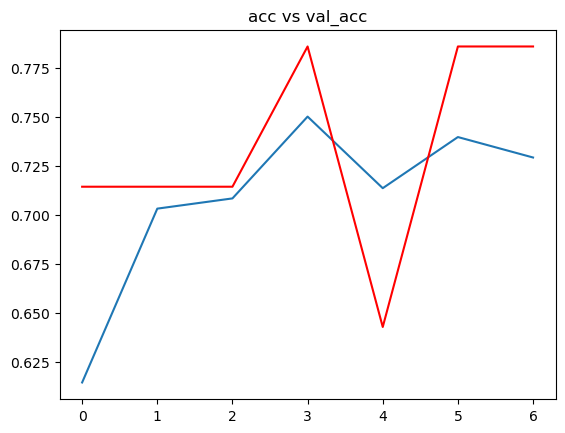

In [33]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c="red")

plt.title("acc vs val_acc")
plt.show()

In [34]:
#model accuracy
from keras.models import load_model

model=load_model('./bestmodel.h5')

In [35]:
accuracy=model.evaluate_generator(test_data)[1]

print(f"the accuracy is {accuracy*100}%")

the accuracy is 92.85714030265808%


In [36]:
from keras.preprocessing.image import load_img,img_to_array

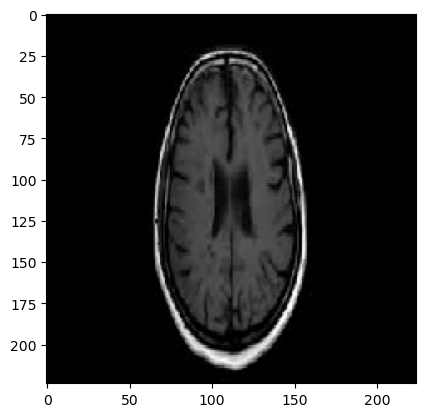

1/1 [==============================] - 0s 467ms/step
No tumor


In [37]:
path = "brain_tumor_dataset/no/11 no.jpg"

img = load_img(path, target_size=(224, 224))
input_arr = img_to_array(img) / 255

plt.imshow(input_arr)
plt.show()

input_arr = np.expand_dims(input_arr, axis=0)

# Make predictions
predictions = model.predict(input_arr)

# Assuming predictions is the output from model.predict
threshold = 0.5
pred_class = 1 if predictions[0, 0] > threshold else 0

# Print the predicted class
if pred_class == 0:
    print("No tumor")
else:
    print("Tumor present")


In [38]:
train_data.class_indices

{'no': 0, 'yes': 1}